<a href="https://colab.research.google.com/github/altinodantas/aircraftsdatasetgenerator/blob/main/Aircraft_classification_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with fine-tuning to aircraft classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data preprocessing

### Data download

In [3]:
"""
Dataset of manufactures (Embraer vs Airbus)
"""
# train_dir = "/content/drive/MyDrive/planes/embraer-bombardier-models/train"
# validation_dir = "/content/drive/MyDrive/planes/embraer-bombardier-models/validation"

"""
Dataset of aircraft models 
"""
train_dir = "/content/drive/MyDrive/planes/aircrafts-models/train/selected"
validation_dir = "/content/drive/MyDrive/planes/aircrafts-models/validation/selected"

BATCH_SIZE = 32
IMG_SIZE = (225,400)

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 3112 files belonging to 6 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 936 files belonging to 6 classes.


In [6]:
number_of_classes = len(train_dataset.class_names)

In [7]:
train_dataset.class_names

['Airbus+A340-642',
 'Antonov+An-225+Mriya',
 'Boeing+727%3B',
 'Boeing+747-830',
 'Boeing+787-9+Dreamliner',
 'Embraer+190-400STD']

Show the first nine images and labels from the training set:

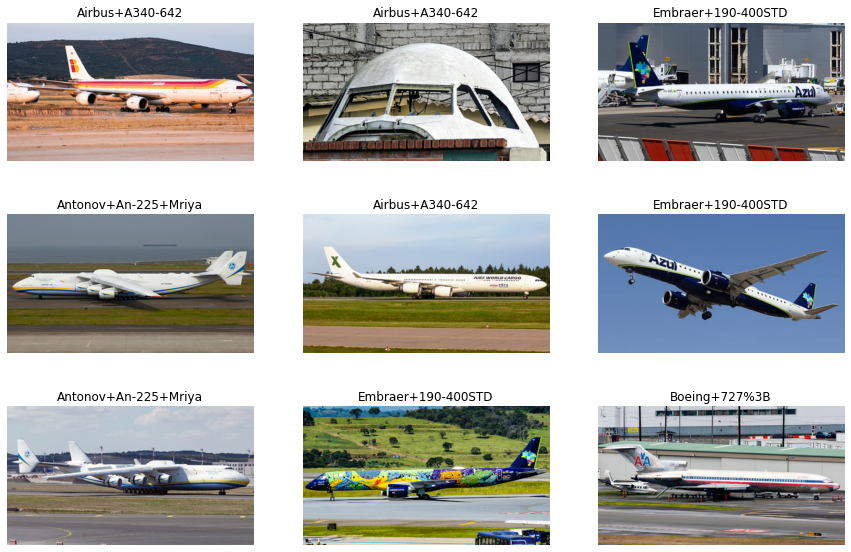

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 24
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

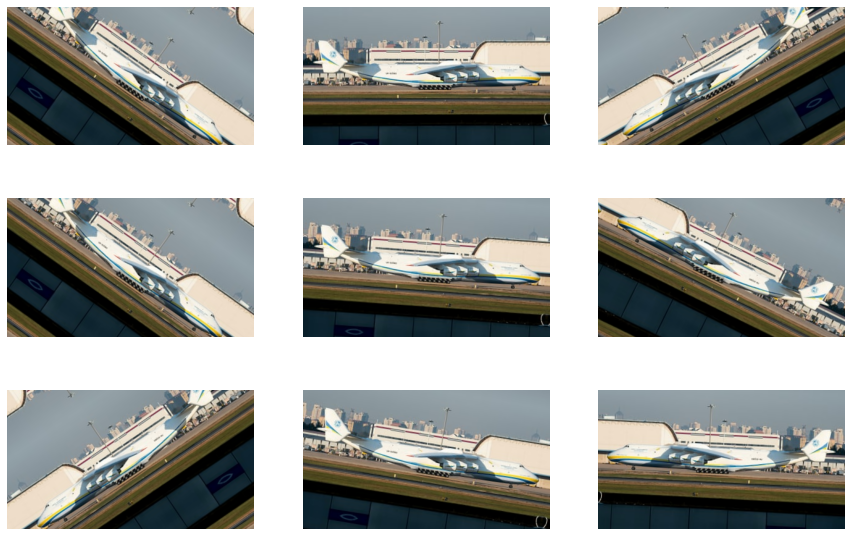

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(15, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model based on MobileNet

### Rescale pixel values


In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Pre-trained model

In [17]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [18]:
IMG_SHAPE

(225, 400, 3)

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 13, 1280)


In [20]:
base_model.trainable = False

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [22]:
prediction_layer = tf.keras.layers.Dense(number_of_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [23]:
inputs = tf.keras.Input(shape=(225, 400, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are many classes, labeled with integer, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss with `from_logits=True`.

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model



#### Check model performance with initial weights 

In [25]:
loss0, accuracy0 = model.evaluate(validation_dataset)

24/24 [==============================] - 212s 4s/step - loss: 1.8568 - accuracy: 0.1855


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.86
initial accuracy: 0.19


In [27]:
initial_epochs = 10

In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
98/98 [==============================] - 625s 6s/step - loss: 1.8023 - accuracy: 0.2230 - val_loss: 1.7255 - val_accuracy: 0.2675
Epoch 2/10
98/98 [==============================] - 21s 212ms/step - loss: 1.6756 - accuracy: 0.3120 - val_loss: 1.6244 - val_accuracy: 0.3347
Epoch 3/10
98/98 [==============================] - 21s 211ms/step - loss: 1.5585 - accuracy: 0.3975 - val_loss: 1.5314 - val_accuracy: 0.4341
Epoch 4/10
98/98 [==============================] - 22s 212ms/step - loss: 1.4717 - accuracy: 0.4717 - val_loss: 1.4533 - val_accuracy: 0.4987
Epoch 5/10
98/98 [==============================] - 21s 212ms/step - loss: 1.3752 - accuracy: 0.5482 - val_loss: 1.3875 - val_accuracy: 0.5457
Epoch 6/10
98/98 [==============================] - 21s 211ms/step - loss: 1.3187 - accuracy: 0.5736 - val_loss: 1.3197 - val_accuracy: 0.6102
Epoch 7/10
98/98 [==============================] - 22s 212ms/step - loss: 1.2521 - accuracy: 0.6163 - val_loss: 1.2680 - val_accuracy: 0.6465
E

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

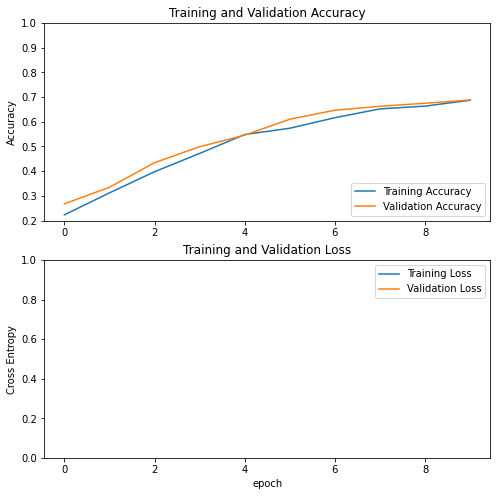

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Un-freeze the top layers of the model


In [30]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [32]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 225, 400, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 225, 400, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 225, 400, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 225, 400, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 13, 1280)      2257984   
 ional)                                                          
                                                             

In [34]:
len(model.trainable_variables)

56

### Continue training the model

In [35]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
98/98 [==============================] - 38s 305ms/step - loss: 0.6934 - accuracy: 0.7709 - val_loss: 0.5626 - val_accuracy: 0.8454
Epoch 11/20
98/98 [==============================] - 29s 292ms/step - loss: 0.4837 - accuracy: 0.8477 - val_loss: 0.4558 - val_accuracy: 0.8656
Epoch 12/20
98/98 [==============================] - 30s 294ms/step - loss: 0.3726 - accuracy: 0.8792 - val_loss: 0.3415 - val_accuracy: 0.8965
Epoch 13/20
98/98 [==============================] - 29s 292ms/step - loss: 0.3067 - accuracy: 0.9046 - val_loss: 0.3804 - val_accuracy: 0.8723
Epoch 14/20
98/98 [==============================] - 30s 294ms/step - loss: 0.2546 - accuracy: 0.9145 - val_loss: 0.2520 - val_accuracy: 0.9167
Epoch 15/20
98/98 [==============================] - 29s 291ms/step - loss: 0.2122 - accuracy: 0.9380 - val_loss: 0.3017 - val_accuracy: 0.9005
Epoch 16/20
98/98 [==============================] - 30s 294ms/step - loss: 0.1855 - accuracy: 0.9402 - val_loss: 0.2031 - val_accuracy:

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

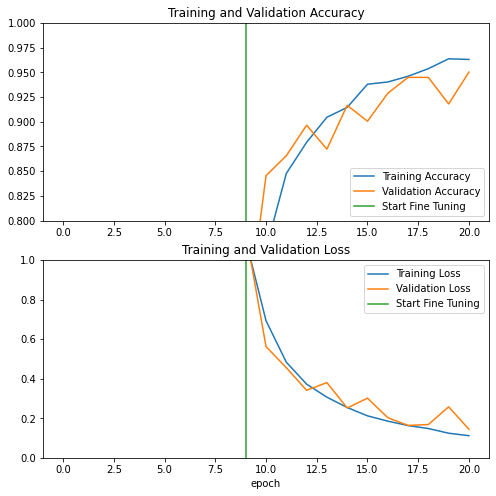

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 156ms/step - loss: 0.1661 - accuracy: 0.9271
Test accuracy : 0.9270833134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [5 5 1 0 2 3 1 3 4 3 2 4 2 0 5 0 0 5 0 1 0 2 4 2 4 1 1 1 1 4 3 1]
Labels:
 [5 5 1 0 2 3 1 3 4 3 2 4 2 0 5 0 0 5 0 1 0 2 4 2 4 1 1 1 1 4 3 1]


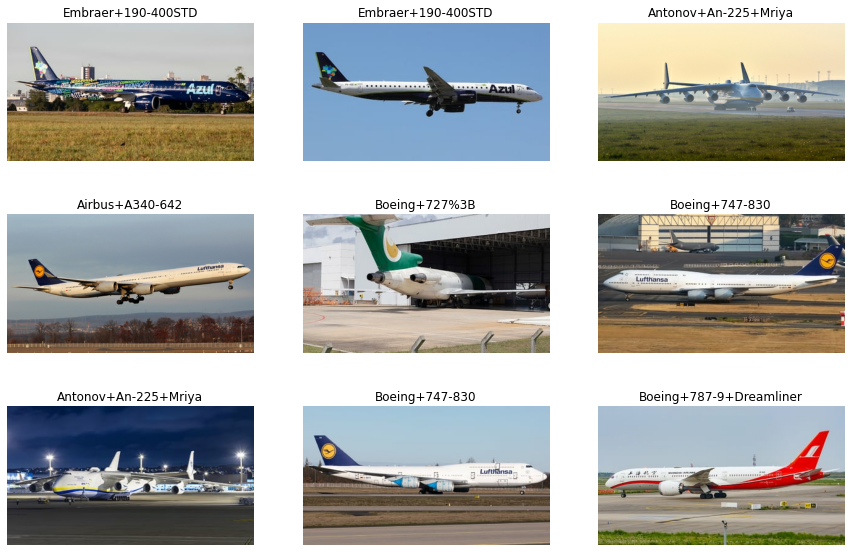

In [44]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)


# Apply a softmax since there are many classes (aircraft models)
predictions = tf.nn.softmax(predictions)
predictions = tf.math.argmax(predictions,axis=1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(15, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [40]:
class_names

['Airbus+A340-642',
 'Antonov+An-225+Mriya',
 'Boeing+727%3B',
 'Boeing+747-830',
 'Boeing+787-9+Dreamliner',
 'Embraer+190-400STD']

In [43]:
model.save("/content/drive/MyDrive/planes/aircraft_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Confusion matrix

In [41]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [42]:
matrix = tf.math.confusion_matrix(correct_labels, predicted_labels)
matrix

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[33,  0,  0,  2,  3,  0],
       [ 0, 34,  0,  0,  0,  0],
       [ 0,  0, 23,  0,  1,  0],
       [ 1,  0,  0, 42,  1,  0],
       [ 0,  0,  0,  0, 27,  1],
       [ 0,  0,  1,  0,  2, 21]], dtype=int32)>

In [43]:
class_names

['Airbus+A340-642',
 'Antonov+An-225+Mriya',
 'Boeing+727%3B',
 'Boeing+747-830',
 'Boeing+787-9+Dreamliner',
 'Embraer+190-400STD']